In [87]:
# import pyspark.sql.functions as F
# from datetime import datetime, timedelta, date
# from pyspark.sql.types import TimestampType
# from pyspark.sql.functions import sum, to_date, col, when, month, dayofmonth, explode, array, struct, expr, lit , avg
import geopandas as gpd
# import matplotlib.pyplot as plt
from shapely import wkt, Point

import pandas as pd
import os

In [88]:
#load geojson polygon file
cells = gpd.read_file(f"../data/neerslag_ai/polygons_irc.geojson")
cells.index = cells["index"]
cells = cells.drop(columns=['index'])
cells

,geometry
index,
polygon_0,"POLYGON ((72370.233 420696.363, 73323.192 4206..."
polygon_1,"POLYGON ((73323.192 420610.729, 74276.142 4205..."
polygon_2,"POLYGON ((74276.142 420525.047, 75229.083 4204..."
polygon_3,"POLYGON ((75229.083 420439.316, 76182.016 4203..."
polygon_4,"POLYGON ((76182.016 420353.537, 77134.939 4202..."
...,...
polygon_3545,"POLYGON ((130906.100 368332.151, 131856.103 36..."
polygon_3546,"POLYGON ((131856.103 368243.772, 132806.098 36..."
polygon_3547,"POLYGON ((132806.098 368155.346, 133756.083 36..."


<Axes: >

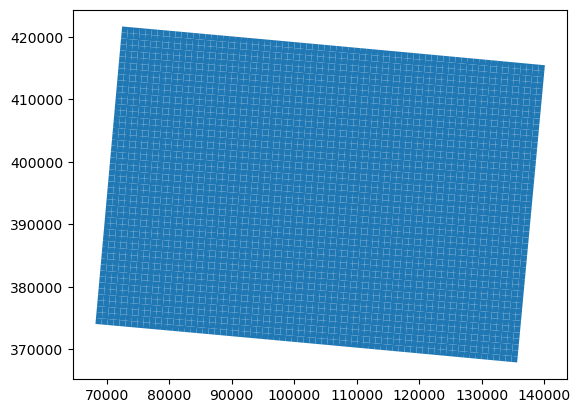

In [89]:
# Create a GeoDataFrame from the Pandas DataFrame
cells = gpd.GeoDataFrame(cells, geometry="geometry")

# Define the RD New and WGS84 CRS
crs_rd = "EPSG:28992"
crs_wgs84 = "EPSG:4326"

# Set the CRS of the original GeoDataFrame to RD New
cells.crs = crs_rd

# Convert the coordinates to WGS84 using .to_crs()
cells_84 = cells.to_crs(crs_wgs84)

# Plot the geometries using GeoPandas
cells.plot()

In [90]:
cells_84 = cells.to_crs(crs_wgs84)
cells_84

,geometry
index,
polygon_0,"POLYGON ((4.19008 51.76883, 4.20390 51.76820, ..."
polygon_1,"POLYGON ((4.20390 51.76820, 4.21773 51.76757, ..."
polygon_2,"POLYGON ((4.21773 51.76757, 4.23155 51.76694, ..."
polygon_3,"POLYGON ((4.23155 51.76694, 4.24537 51.76630, ..."
polygon_4,"POLYGON ((4.24537 51.76630, 4.25919 51.76566, ..."
...,...
polygon_3545,"POLYGON ((5.04170 51.30375, 5.05533 51.30299, ..."
polygon_3546,"POLYGON ((5.05533 51.30299, 5.06895 51.30223, ..."
polygon_3547,"POLYGON ((5.06895 51.30223, 5.08258 51.30148, ..."


In [91]:
point = Point(4.586668, 51.558512)

In [92]:
result = cells_84[cells_84['geometry'].contains(point)]
result

,geometry
index,
polygon_1663,"POLYGON ((4.57913 51.55202, 4.59286 51.55134, ..."


In [93]:
from concurrent.futures import ThreadPoolExecutor

final_df_list = []
polygon_name = 'polygon_1663'
columns_to_read = ['timestamp', polygon_name, 'data_source']
columns_to_read_without_data_source = ['timestamp', polygon_name]
# Function to process each file
def process_file(file: str):
    if os.path.splitext(file)[1] == '.parquet' and '_delta_log' not in root:
        file_path = os.path.join(root, file)
        try:  
            # Read only the specified columns
            df_weather = pd.read_parquet(file_path, columns=columns_to_read)
            print("source: " + file_path)
            return df_weather
        except Exception as e:
            try:
                # Read only the specified columns
                df_weather = pd.read_parquet(file_path, columns=columns_to_read_without_data_source)
                df_weather['data_source'] = None
                print("source: " + file_path)
                return df_weather
            except Exception as e:
                raise Exception(f"Error reading file {file_path}: {e}")

# Use ThreadPoolExecutor to parallelize file processing
with ThreadPoolExecutor() as executor:
    walker = os.walk("../data/neerslag_ai/")
    for root, dirs, files in walker:
        # Process each file concurrently
        result = list(executor.map(process_file, files))
        final_df_list.extend(result)

# Concatenate all DataFrames in the list
final_df = pd.concat(final_df_list, ignore_index=True)

print('\n------------------\n Done \n------------------\n')

source: ../data/neerslag_ai/year=2022/month=1/day=1/part-00003-25053f1f-c253-464e-ab7b-a339aef5a254.c000.snappy.parquet
source: ../data/neerslag_ai/year=2022/month=1/day=10/part-00009-458a8377-5348-4212-877a-72b7aa16e4ca.c000.snappy.parquet
source: ../data/neerslag_ai/year=2022/month=1/day=11/part-00006-b8d33224-d6f9-40fd-b015-fee2e1b6a61c.c000.snappy.parquet
source: ../data/neerslag_ai/year=2022/month=1/day=12/part-00007-1ea8f428-e98a-45b5-b3a4-fdcb21adc4a1.c000.snappy.parquet
source: ../data/neerslag_ai/year=2022/month=1/day=13/part-00004-26983ec2-95e0-48cf-a7a9-e7af1bf4fa1a.c000.snappy.parquet
source: ../data/neerslag_ai/year=2022/month=1/day=14/part-00000-72f016f1-28e1-48fe-9d90-34621c38f8fb.c000.snappy.parquet
source: ../data/neerslag_ai/year=2022/month=1/day=15/part-00006-ab3a2e3d-eb27-4a11-b25a-41a985c1de80.c000.snappy.parquet
source: ../data/neerslag_ai/year=2022/month=1/day=16/part-00002-7a4c84a8-c14a-4dc5-bee9-8a005b10b630.c000.snappy.parquet
source: ../data/neerslag_ai/year=

In [94]:
final_df.sort_values(by=['timestamp'], inplace=True)
final_df = final_df.reset_index(drop=True)
final_df

,timestamp,polygon_1663,data_source
0,2019-01-01 00:00:00,0.000000,final_reanalysis
1,2019-01-01 00:05:00,0.000000,final_reanalysis
2,2019-01-01 00:10:00,0.000000,final_reanalysis
3,2019-01-01 00:15:00,0.000000,final_reanalysis
4,2019-01-01 00:20:00,0.000000,final_reanalysis
...,...,...,...
676924,2023-12-11 08:30:00,0.020020,realtime
676925,2023-12-11 08:35:00,0.039978,realtime
676926,2023-12-11 08:40:00,0.020020,realtime
676927,2023-12-11 08:45:00,0.000000,realtime


In [95]:
unique_values = final_df['data_source'].unique()

# Define the precedence order
precedence_order = { 'final_reanalysis': 0, 'early_reanalysis': 1, 'realtime': 2, None: 3}

# Replace 'your_column_name' with the actual name of the column
final_df['data_source_order'] = final_df['data_source'].map(precedence_order)

# Sort the DataFrame based on 'timestamp' and 'data_source_order'
final_df_sorted = final_df.sort_values(by=['timestamp', 'data_source_order'], ascending=[True, True])

# Drop duplicates based on 'timestamp', keeping the last occurrence in the sorted order
deduplicated_df = final_df_sorted.drop_duplicates(subset='timestamp', keep='last')

# Drop the auxiliary 'data_source_order' column if you don't need it
deduplicated_df = deduplicated_df.drop(columns=['data_source_order'])


deduplicated_df

,timestamp,polygon_1663,data_source
0,2019-01-01 00:00:00,0.000000,final_reanalysis
1,2019-01-01 00:05:00,0.000000,final_reanalysis
2,2019-01-01 00:10:00,0.000000,final_reanalysis
3,2019-01-01 00:15:00,0.000000,final_reanalysis
4,2019-01-01 00:20:00,0.000000,final_reanalysis
...,...,...,...
676924,2023-12-11 08:30:00,0.020020,realtime
676925,2023-12-11 08:35:00,0.039978,realtime
676926,2023-12-11 08:40:00,0.020020,realtime
676927,2023-12-11 08:45:00,0.000000,realtime


In [96]:
rows_with_none_data_source = final_df[final_df['data_source'].isna()]

# Print the rows where data_source is None
rows_with_none_data_source

,timestamp,polygon_1663,data_source,data_source_order


In [97]:
def check_empty_rows(df: pd.DataFrame):
    # Assuming your DataFrame is named 'df' and the timestamp column is named 'timestamp'
    # Make sure the timestamp column is in datetime format
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # Step 1: Check the time range
    min_timestamp = df['timestamp'].min()
    max_timestamp = df['timestamp'].max()
    print(f"Min Timestamp: {min_timestamp}, Max Timestamp: {max_timestamp}")

    # Step 2: Check the time difference between consecutive rows
    time_diff = df['timestamp'].diff().dropna()
    expected_time_diff = pd.Timedelta(minutes=5)

    # Identify gaps excluding cases where the time difference is zero
    gaps = time_diff[(time_diff != expected_time_diff) & (time_diff != pd.Timedelta(0))]

    # Check if there are any gaps
    if not gaps.empty:
        print("Gaps found. Time ranges with missing rows:")
        for idx in gaps.index:
            if 0 <= idx - 1 < len(df) and 0 <= idx < len(df):
                print(f"Row {idx}: {df['timestamp'].iloc[idx - 1]} - {df['timestamp'].iloc[idx]}")
    else:
        print("No gaps found. The DataFrame has a row for every five minutes.")

check_empty_rows(deduplicated_df)

Min Timestamp: 2019-01-01 00:00:00, Max Timestamp: 2023-12-11 08:50:00
Gaps found. Time ranges with missing rows:
Row 160: 2019-01-01 13:15:00 - 2019-01-01 13:25:00
Row 340: 2019-01-02 04:20:00 - 2019-01-02 04:30:00
Row 489: 2019-01-02 16:50:00 - 2019-01-02 17:00:00
Row 501: 2019-01-02 17:55:00 - 2019-01-02 18:05:00
Row 522: 2019-01-02 19:45:00 - 2019-01-02 19:55:00
Row 703: 2019-01-03 10:55:00 - 2019-01-03 11:05:00
Row 858: 2019-01-03 23:55:00 - 2019-01-04 00:05:00
Row 898: 2019-01-04 03:20:00 - 2019-01-04 03:30:00
Row 1203: 2019-01-05 04:50:00 - 2019-01-05 05:00:00
Row 2058: 2019-01-08 04:10:00 - 2019-01-08 04:20:00
Row 2320: 2019-01-09 02:05:00 - 2019-01-09 02:15:00
Row 2713: 2019-01-10 10:55:00 - 2019-01-10 11:05:00
Row 2857: 2019-01-10 23:00:00 - 2019-01-10 23:10:00
Row 3107: 2019-01-11 19:55:00 - 2019-01-11 20:05:00
Row 3110: 2019-01-11 20:15:00 - 2019-01-11 20:25:00
Row 3114: 2019-01-11 20:40:00 - 2019-01-11 20:50:00
Row 3129: 2019-01-11 22:00:00 - 2019-01-11 22:10:00
Row 3229: 

In [98]:
# Assuming your DataFrame is named 'final_df'
# Replace 'your_column_name' with the actual name of the column
rows_with_none_data_source = final_df[final_df['data_source'].isna()]

# Print the rows where data_source is None
print(rows_with_none_data_source)

Empty DataFrame
Columns: [timestamp, polygon_1663, data_source, data_source_order]
Index: []


In [99]:
from datetime import datetime
# Generate a DataFrame with all five-minute intervals in 2023
start_date = datetime(2023, 1, 1)
end_date = datetime(2024, 1, 1)
expected_intervals = pd.date_range(start=start_date, end=end_date, freq='5T')
# Identify missing rows
missing_rows = final_df[final_df.isnull().any(axis=1)]

# Display missing rows. Should be an empty dataframe
print("Missing Rows:")
print(missing_rows)

Missing Rows:
Empty DataFrame
Columns: [timestamp, polygon_1663, data_source, data_source_order]
Index: []


In [100]:
final_df.rename(columns={polygon_name: 'precipitation'}, inplace=True)

In [101]:
final_df[['timestamp', 'precipitation']].to_parquet(polygon_name + ".parquet")